In [1]:
# Headers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random

import healpy as hp

from astropy.io import fits
from astropy.table import Table, Column

import treecorr

from scipy.optimize import curve_fit

In [2]:
def calculate_patch_radius(patch_area_sq_degrees):
    return np.arccos(1-patch_area_sq_degrees*np.pi/(2*180*180))

def lognormal_pdf(z, A, log_shift, sigma):
    return np.piecewise(z, [z > -log_shift, z <= -log_shift], 
                        [ lambda z: A*1/(np.sqrt(2*np.pi)*(z+log_shift)*sigma) *
                         np.exp(-(np.log(z/log_shift + 1) + sigma**2/2)**2/(2*sigma**2)), 0])

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<Figure size 864x864 with 0 Axes>

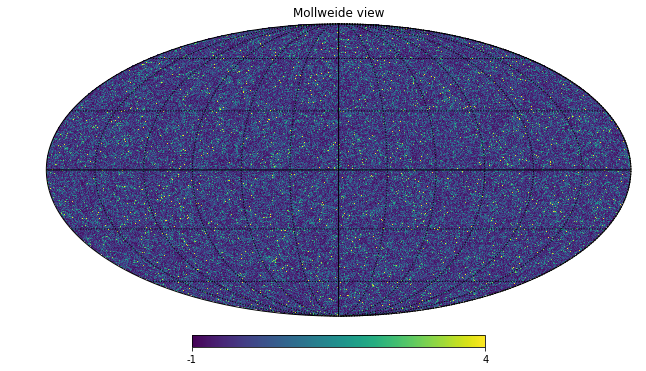

In [3]:
density_field_map = hp.fitsfunc.read_map('./simulations_output/lognormal_map/lognormal_map.fits')

map_type = 'lognormal'

plt.figure(figsize=(12,12))
hp.mollview(density_field_map, min=-1, max=4)
hp.graticule()

In [4]:
nside = 2048

random_pixel = random.randint(0,12*nside**2)
print('Random pixel = ', random_pixel)

Random pixel =  44543859


In [5]:
def fit_lognormal_pdf(density_field, no_of_bins, sq_degrees=40000):
    
    if (sq_degrees == 40000): # i.e. full sky
        
        #no_of_bins = 500
               
        bin_values, bin_edges = np.histogram(density_field, bins=no_of_bins, density=True)
        bin_centers = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)])

        # Fit the function to the histogram data to get the optimized parameter values
        popt, pcov = curve_fit(lognormal_pdf, xdata = bin_centers, ydata = bin_values, p0=[1, 1, 1])

        # Generate enough x values to make the curves look smooth.
        x_space = np.linspace(-2, 8, 1000)

        plt.figure(figsize=(10,10))
        plt.hist(density_field, bins=no_of_bins, density=True, label=r'Histogram entries')
        plt.plot(x_space, lognormal_pdf(x_space, *popt), color='r', linewidth=2.5, label=r'Fitted function')
        plt.xlabel('density fluctuations ($δ$)', fontsize=16)
        plt.tick_params(labelsize=16)
        plt.xlim(-2,8)
        plt.tick_params(labelsize=16)
        plt.xlim(-2,8)
        plt.title('1-pt PDF density fluctuations '+map_type+' map : {0} entries\n Fit: Amplitude  = {1:4.3f}, λ = {2:4.3f}, σ = {3:4.3f}, μ = {4:4.3f}'.format(density_field.size, popt[0], popt[1], popt[2], np.log(popt[1])-popt[2]**2/2), fontsize=14)
        plt.legend(loc='best', fontsize=14)
        
    else:
        patch_radius = calculate_patch_radius(sq_degrees)

        # Center of spherical cap around at random_pixel around which to take sq_degrees area
        disc_center = hp.pix2vec(nside, random_pixel)

        # radius (in radians) corresponding to area of spherical cap in sky

        # find the pixels 
        pixels_indices_disc = hp.query_disc(nside, disc_center, patch_radius)
        density_field_disc = density_field[pixels_indices_disc]
        
        #no_of_bins = 'auto'

        bin_values, bin_edges = np.histogram(density_field_disc, bins=no_of_bins, density=True)
        bin_centers = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)])

        # Fit the function to the histogram data to get the optimized parameter values
        popt, pcov = curve_fit(lognormal_pdf, xdata = bin_centers, ydata = bin_values, p0=[1, 1, 1])

        # Generate enough x values to make the curves look smooth.
        x_space = np.linspace(-2, 8, 1000)

        plt.figure(figsize=(10,10))
        plt.hist(density_field_disc, bins=no_of_bins, density=True, label=r'Histogram entries')
        plt.plot(x_space, lognormal_pdf(x_space, *popt), color='r', linewidth=2.5, label=r'Fitted function')
        plt.xlabel('density fluctuations ($δ$)', fontsize=16)
        plt.tick_params(labelsize=16)
        plt.xlim(-2,8)
        plt.tick_params(labelsize=16)
        plt.xlim(-2,8)
        plt.title('1-pt PDF density fluctuations '+map_type+' map (single patch '+str(sq_degrees)+' sq. degrees) {0} entries\n Fit: Amplitude  = {1:4.3f}, λ = {2:4.3f}, σ = {3:4.3f}, μ = {4:4.3f}'.format(density_field_disc.size, popt[0], popt[1], popt[2], np.log(popt[1])-popt[2]**2/2), fontsize=14)
        plt.legend(loc='best', fontsize=14)    

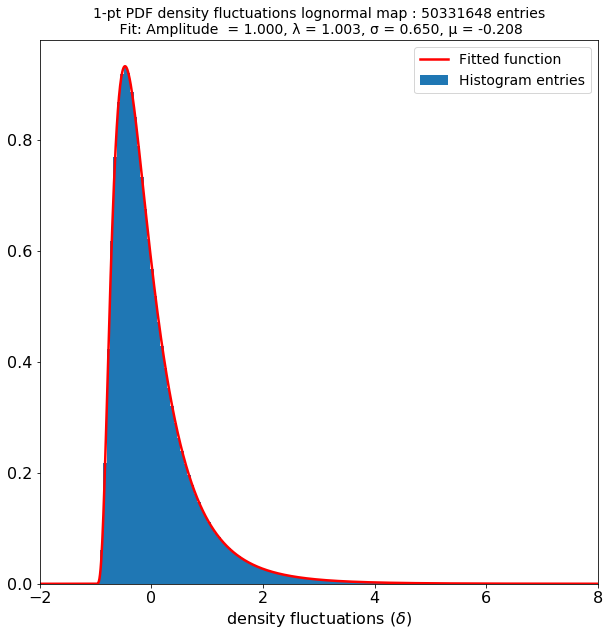

In [6]:
fit_lognormal_pdf(density_field_map, 500) # full sky

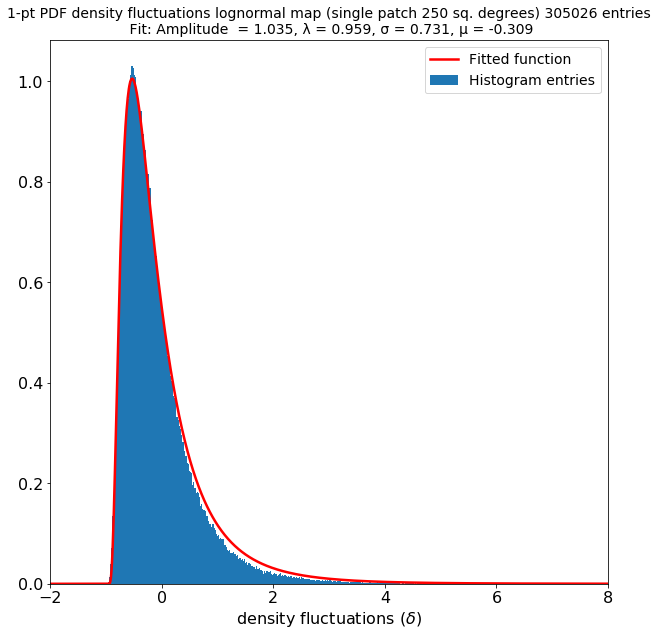

In [7]:
fit_lognormal_pdf(density_field_map, 'auto', 250)

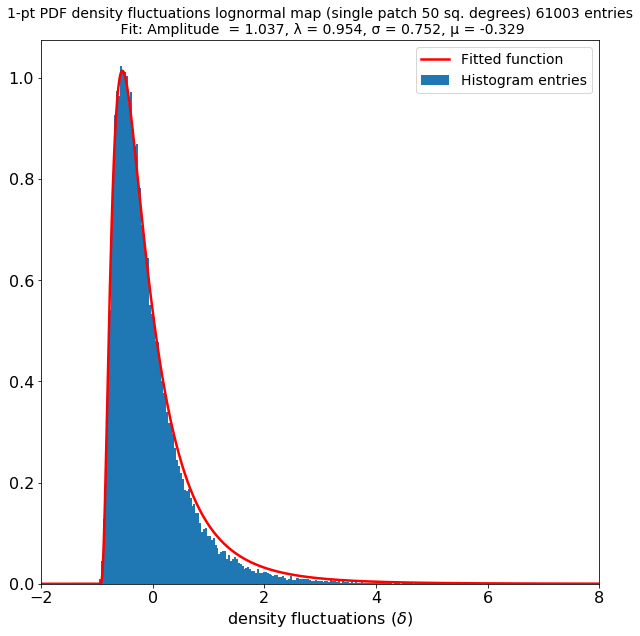

In [8]:
fit_lognormal_pdf(density_field_map, 'auto', 50)

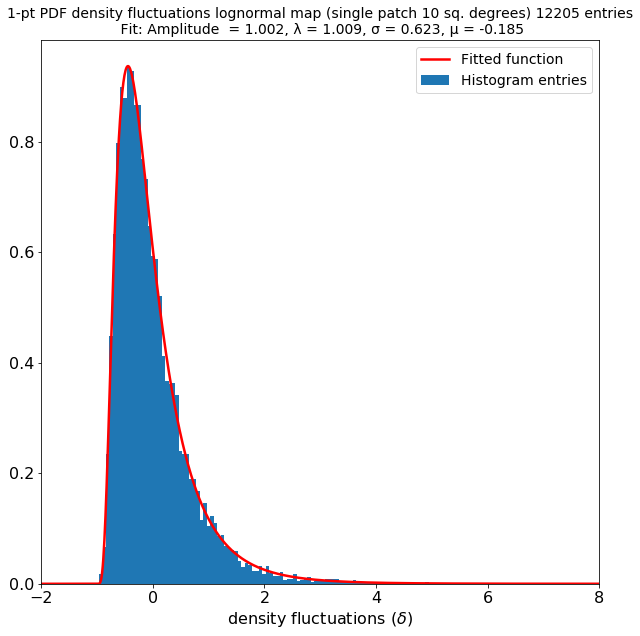

In [9]:
fit_lognormal_pdf(density_field_map, 'auto', 10)

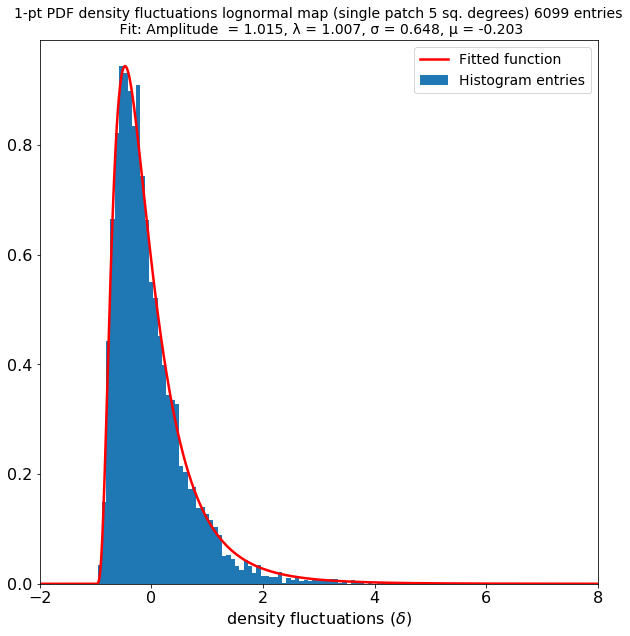

In [10]:
fit_lognormal_pdf(density_field_map, 'auto', 5)

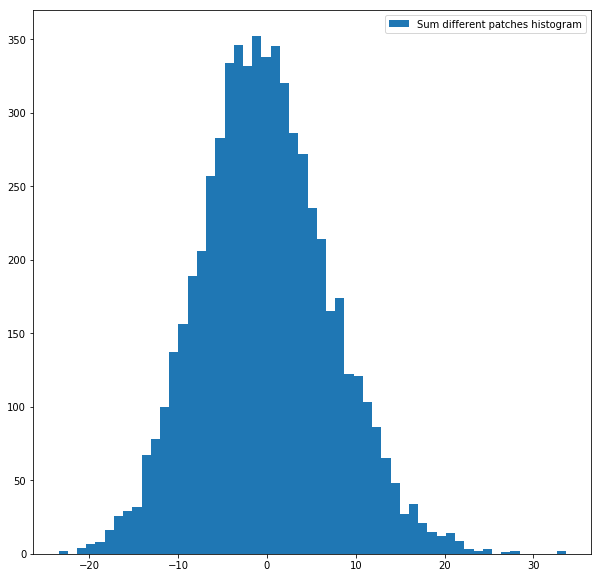

In [11]:
### distribution of sum of density fluctuations in different patches

entries = 6000
patches = 100
sum_arr = np.zeros(entries)

for i in range(patches):
    random_pixel = random.randint(0,12*nside**2)

    # Center of spherical cap around at random_pixel around which to take sq_degrees area
    disc_center = hp.pix2vec(nside, random_pixel)
    
    sq_degrees_list = [5,10,50,250]
    sq_degrees = random.choice(sq_degrees_list)

    sq_degrees = 10
    
    patch_radius = calculate_patch_radius(sq_degrees)
    
    # find the pixels 
    pixels_indices_disc = hp.query_disc(nside, disc_center, patch_radius)
    density_field_disc = density_field_map[pixels_indices_disc]
    np.random.shuffle(density_field_disc)
    sum_arr += density_field_disc[:entries]
    
plt.figure(figsize=(10,10))
plt.hist(sum_arr, bins='auto', label=r'Sum different patches histogram')
plt.legend()